In [ ]:
!pip install susi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 851.4 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for susi: filename=susi-1.4.0-py3-none-any.whl size=26733 sha256=13a3a5f9cac2db9af65224733dcbfa3e60ffc024663a0028c572d90b04ca3ad4
  Stored in directory: /root/.cache/pip/wheels/a9/14/88/3e2bf6be56b38907e5dc198d85473c9144076605f4ff4e9bd2
Successfully built susi


In [ ]:
import susi
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [ ]:
df = pd.read_csv('BTC-USD.csv')
df=df[['Date','Close']]
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df,
                                '2014-09-24',
                                '2024-03-17',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2014-09-24,398.821014,402.152008,435.790985,423.204987
1,2014-09-25,402.152008,435.790985,423.204987,411.574005
2,2014-09-26,435.790985,423.204987,411.574005,404.424988
3,2014-09-27,423.204987,411.574005,404.424988,399.519989
4,2014-09-28,411.574005,404.424988,399.519989,377.181000
...,...,...,...,...,...
3458,2024-03-13,69019.789063,72123.906250,71481.289063,73083.500000
3459,2024-03-14,72123.906250,71481.289063,73083.500000,71396.593750
3460,2024-03-15,71481.289063,73083.500000,71396.593750,69403.773438
3461,2024-03-16,73083.500000,71396.593750,69403.773438,65315.117188


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
print(dates.shape)

(3463,)


In [ ]:
# q_80 = int(len(dates) * .8)
# q_90 = int(len(dates) * .9)

# dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
# dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

In [ ]:
dates_train,dates_test,X_train,X_test,y_train,y_test = train_test_split(dates,X,y,test_size=0.2)

In [ ]:
X_train = X_train.reshape(-1, 3)
print(y_train)
# param_grid = {
#     "n_rows": [3],
#     "n_columns": [260],
#     "learning_rate_start": [1.11, 1.110,1.111,1.112],
#     "learning_rate_end": [0.7],
# }
# som = susi.SOMRegressor()
# clf = GridSearchCV(som, param_grid,cv=5,n_jobs=-1)
# clf.fit(X_train, y_train)
# print(clf.best_params_)

[47945.06    3399.4717  8293.868  ... 51206.69   17196.555   8510.38  ]


In [ ]:
# print(clf.best_score_)

In [ ]:
som1 = susi.SOMRegressor(
    n_rows = 3,
    n_columns = 260,
    learning_rate_start = 1.112,
    learning_rate_end = 0.7
)
som1.fit(X_train,y_train)

SOMRegressor(learning_rate_end=0.7, learning_rate_start=1.112, n_columns=260,
             n_rows=3)

In [ ]:
X_test = X_test.reshape(-1,3)
predicted = som1.predict(X_test)
print(predicted)

[ 7175.10280912   512.05107972 25730.82423825 17658.70319354
 41933.59995325   670.82095938  7153.76535266 28205.91310931
  5770.06745189   411.10717506  7232.36476166   764.31724119
  7392.0837738    316.99163363  1162.68575702  1096.53325911
 44507.19490451 35683.02569329   257.46342056   355.55044224
 52112.0840833  42043.91339548 51671.33500309   943.79863324
   704.29513333 41841.77326279  7153.76535266   325.71499342
  6102.62246989  7936.31280378 52112.0840833    636.35106965
  9922.99687431   774.45316273  3803.43594367  7648.49087271
 22599.09929903   257.46342056   645.68280362  9919.56805594
   257.46342056  1714.71266683   582.44614218   560.12661386
  5927.34844427 41772.06934776 52112.0840833  20755.95489639
   645.68280362 45956.62418334 27617.93525375  1437.52300715
   393.79727507   299.77548954  1057.88802756 20682.04767896
  5967.47683168   295.83790621  9489.24683313  3462.44543142
   645.68280362 42388.56172572 11592.25090499  4448.03175648
  4032.42823441 39209.42

In [ ]:
print(y_test.shape)
R2 =r2_score(y_test,predicted)
print("R2 score : ",R2)

(693,)
R2 score :  0.9796273382929096


In [ ]:
aR2 = 1 - ((1-R2)*(693-1)/(693-1-6))
print("Adjusted R2 :",aR2)

Adjusted R2 : 0.9794491517473666


In [ ]:
MAE = mean_absolute_error(y_test,predicted)
print("MAE : ",MAE)

MAE :  965.0177566895885


In [ ]:
MSE = mean_squared_error(y_test,predicted)
print("MSE : ",MSE)

MSE :  6133216.033849531


In [ ]:
print("RMSE :",np.sqrt(MSE))

RMSE : 2476.5330673846315


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1,1))

test_predict = scaler.inverse_transform(predicted.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
n=len(test_predict)
dates_test1= dates_test
for i in range(n):
  test_predict[i]=float(test_predict[i][0])
  original_ytest[i]=float(original_ytest[i][0])
d=dict()
d1=dict()
for i in range(n):
  d[dates_test[i]]=test_predict[i]
  d1[dates_test[i]]=original_ytest[i]
dates_test.sort()
test_predict1=list()
for i in range(n):
  test_predict1.append(d[dates_test[i]])
original_ytest1=list()
for i in range(n):
  original_ytest1.append(d1[dates_test[i]])

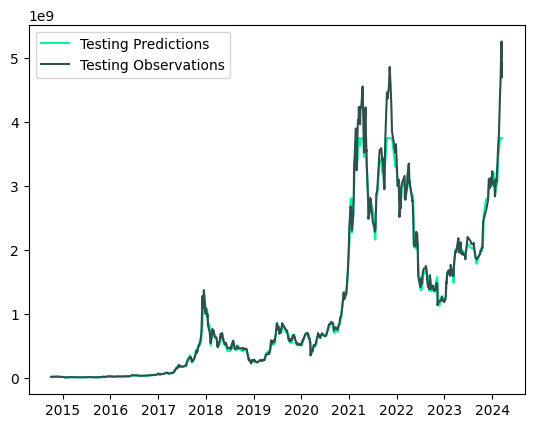

In [ ]:
plt.plot(dates_test,test_predict1,color='mediumspringgreen')
plt.plot(dates_test,original_ytest1,color='darkslategray')
plt.legend(['Testing Predictions', 'Testing Observations'])
# print(X_test.getIndexOf())
# print(Y_test)